# Examine the response of the cell to one image

In [2]:
%load_ext autoreload
%autoreload 2


from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"



In [21]:
import time

import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
import h5py

import jaxley as jx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.animation as animation

import sys
sys.path.append("/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph")
sys.path.append("/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/experiments/temporally_resolved_response")
from utils.data_utils import (
    read_data,
    build_avg_recordings,
    build_training_data,
)
from utils.utils import (
    build_cell,
    build_kernel,
)
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import utils_temp.utils_temp

### load data 

In [4]:
#
path_prefix ="/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph"
results_prefix = "results/train_runs/2020-08-29_40_-1_5_bc_40um/0/"
save_prefix = "/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/experiments/temporally_resolved_response/results_temp/2020-08-29_40_-1_5_bc_40um/"
mlp_rc_path = "/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/.matplotlibrc"
start_n_scan = 100
num_datapoints_per_scanfield = 64 
nseg = 4
cell_id = "2020-08-29_1"
rec_ids = [0,1,2]

In [5]:
stimuli, recordings, setup, noise_full = read_data(
    start_n_scan,
    num_datapoints_per_scanfield,
    cell_id,
    rec_ids,
    "noise",
    path_prefix
)

build_recordings = False
if build_recordings:
    avg_recordings = build_avg_recordings(
        recordings, rec_ids, nseg, num_datapoints_per_scanfield
    )
    with open(f"{path_prefix}/results/intermediate/avg_recordings.pkl", "wb") as handle:
        pickle.dump(avg_recordings, handle)
else:
    with open(f"{path_prefix}/results/intermediate/avg_recordings.pkl", "rb") as handle:
        avg_recordings = pickle.load(handle)


number_of_recordings_each_scanfield = list(avg_recordings.groupby("rec_id").size())

In [6]:
## build training data
warmup = 5.0
i_amp = 0.1

currents, labels, loss_weights = build_training_data(
    i_amp,
    stimuli,
    avg_recordings,
    rec_ids, 
    num_datapoints_per_scanfield,
    number_of_recordings_each_scanfield,
)

stim_branch_inds = stimuli["branch_ind"].to_numpy()
stim_comps = stimuli["comp"].to_numpy()

In [7]:
# set parameters of simulation
dt = 0.025
t_max = 200.0
time_vec = np.arange(0, t_max+2*dt, dt)

In [8]:
def value_from_parameters(parameter_values, distance):
    return parameter_values
    
def simulate(params, basal_neuron_params, somatic_neuron_params, currents):
    """Run simulation and return recorded voltages."""
    syn_weights = params[0]["w_bc_to_rgc"]
    cell_params = params[1:]

    input_currents = syn_weights * currents
    
    # Define stimuli.
    step_currents = jx.datapoint_to_step_currents(warmup, t_max-warmup, input_currents, dt, t_max)
    data_stimuli = None
    for branch, comp, step_current in zip(stim_branch_inds, stim_comps, step_currents):
        data_stimuli = cell.branch(branch).loc(comp).data_stimulate(step_current, data_stimuli=data_stimuli)

    # Define parameters.
    pstate = None
    for param in basal_neuron_params:
        name = list(param.keys())[0]
        parameter_values = param[name]
        value = value_from_parameters(parameter_values, 0.0)
        pstate = cell[basal_inds].data_set(name, value, param_state=pstate)

    for param in somatic_neuron_params:
        name = list(param.keys())[0]
        parameter_values = param[name]
        value = value_from_parameters(parameter_values, 0.0)
        pstate = cell[somatic_inds].data_set(name, value, param_state=pstate)

    # Run simulation.
    v = jx.integrate(
        cell,
        params=cell_params,
        param_state=pstate,
        data_stimuli=data_stimuli,
        checkpoint_lengths=[90, 90]
    )
    return v

sim = jit(simulate)
vmapped_sim = jit(vmap(simulate, in_axes=(None, None, None, 0)))


### build cell and retrieve parameters


In [9]:
cell = build_cell(cell_id, nseg, 5.0, path_prefix)
basal_inds = list(np.unique(cell.basal.nodes['global_branch_index'].to_numpy()))
somatic_inds = list(np.unique(cell.soma.nodes['global_branch_index'].to_numpy()))

/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/utils/misc_utils.py:97: UserWarning: nseg is deprecated and will be removed in version 0.6.0.
  warnings.warn(msg + self._amend_msg)
/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(
/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/io/swc.py:63: UserWarning: Found a segment with length 0. Clipping it to 1.0
  warn("Found a segment with length 0. Clipping it to 1.0")


In [10]:
# insert recordings in cell
cell.delete_recordings()
cell.delete_stimuli()

# branches and comps to record from 

rec_branches_and_compartments = [(rec["branch_ind"], rec["comp"]) for idx,rec in avg_recordings.iterrows()]

for b, c in rec_branches_and_compartments:
    cell.branch(b).loc(c).record("v", verbose=False) # voltage
    cell.branch(b).loc(c).record("Cai", verbose=False) # calcium


print(f"Inserted {len(cell.recordings)} recordings")
print(f"number_of_recordings_each_scanfield {number_of_recordings_each_scanfield}")
number_of_recordings = np.sum(number_of_recordings_each_scanfield)

Inserted 18 recordings
number_of_recordings_each_scanfield [2, 2, 5]


In [11]:

# retrieve parameters 
with open(f"{path_prefix}/{results_prefix}/opt_params/params_10.pkl", "rb") as handle:
    all_opt_params = pickle.load(handle)

with open(f"{path_prefix}/{results_prefix}/transforms/transform_params.pkl", "rb") as handle:
    transform_params = pickle.load(handle)

with open(f"{path_prefix}/{results_prefix}/transforms/transform_basal.pkl", "rb") as handle:
    transform_basal = pickle.load(handle)

with open(f"{path_prefix}/{results_prefix}/transforms/transform_somatic.pkl", "rb") as handle:
    transform_somatic = pickle.load(handle)

opt_params, opt_basal_params, opt_somatic_params = all_opt_params

parameters = transform_params.forward(opt_params)
basal_neuron_params = transform_basal.forward(opt_basal_params)
somatic_neuron_params = transform_somatic.forward(opt_somatic_params)

### run simulation and save results

In [12]:
os.makedirs(save_prefix, exist_ok=True)
data_pt_idx = 0

vcai_path = os.path.join(save_prefix, "v_and_cai.pkl")
recompute = False

test_currents = currents[data_pt_idx]
if os.path.exists(vcai_path) and not recompute:
    print("loading ...")
    with open(vcai_path, "rb") as handle:
        v_trained = pickle.load(handle)

    # load other data
    with open(f"{save_prefix}/noise_image.pkl", "rb") as handle:
        noise_image = pickle.load(handle)
    
    with open(f"{save_prefix}/time_vec.pkl", "rb") as handle:
        time_vec = pickle.load(handle)

else:
    print("recomputing ...")
    v_trained = sim(
        transform_params.forward(opt_params), 
        transform_basal.forward(opt_basal_params),
        transform_somatic.forward(opt_somatic_params),
        test_currents,
    )
    # save v_trained
    with open(f"{save_prefix}/v_and_cai.pkl", "wb") as handle:
        pickle.dump(v_trained, handle)

    # save other data
    with open(f"{save_prefix}/noise_image.pkl", "wb") as handle:
        pickle.dump(noise_full[:, :, data_pt_idx], handle)
    with open(f"{save_prefix}/time_vec.pkl", "wb") as handle:
        pickle.dump(time_vec, handle)

loading ...


### Visualize the image, bc activity and inputs to the cell

/tmp/ipykernel_540471/719177433.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


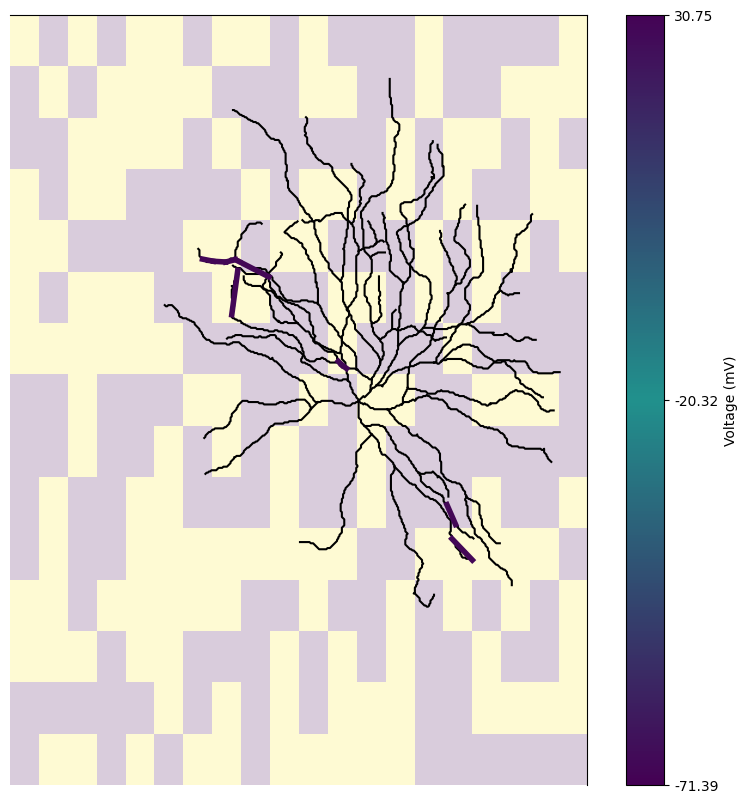

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

cmap = cm.get_cmap('viridis')

nr_comps = len(rec_branches_and_compartments)
t_idx = 0
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cell.vis(ax=ax)

# Determine the min, max, and midpoint of your voltage data
vmin = v_trained.min()
vmax = v_trained.max()
vmid = (vmin + vmax) / 2

# Create a new colormap that maps vmin, vmax, and vmid to the appropriate colors in viridis
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "adjusted_viridis",
    [cmap(0), cmap((vmid - vmin) / (vmax - vmin)), cmap(1)],  # Map min, mid, max
    N=256,  # Number of colors in the new colormap
)

# Add the noise stimulus to the plot
pixel_size = 30
rec_id_of_datapoint = int(data_pt_idx // num_datapoints_per_scanfield)
df = setup.loc[setup["rec_id"] == rec_id_of_datapoint]
df = df.iloc[0]
im_pos_x = np.linspace(-7.5*pixel_size + 0.5, 7.5*pixel_size - 0.5, 15*pixel_size) + df["image_center_x"].item()
im_pos_y = -np.linspace(-10.0*pixel_size + 0.5, 10.0*pixel_size - 0.5, 20*pixel_size) + df["image_center_y"].item()
image = noise_full[:, :, data_pt_idx]
_ = ax.imshow(image, extent=[im_pos_x[0], im_pos_x[-1], im_pos_y[-1], im_pos_y[0]], clim=[0, 1], alpha=0.2, cmap="viridis")


for idx, (branch_idx, comp_loc) in enumerate(rec_branches_and_compartments):
    voltage = v_trained[idx, t_idx]
    color = new_cmap((voltage - vmin) / (vmax - vmin)) #scale the voltage to 0-1 range for the colormap
    cell.branch(branch_idx).loc(comp_loc).vis(ax=ax, color=color,lw=4)

# Remove spines and ticks
_ = ax.spines["left"].set_visible(False)
_ = ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

# Add a colorbar with explicitly set ticks
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)  # ax=ax is crucial here
cbar.set_label('Voltage (mV)')
cbar.ax.set_yticks([vmin, vmid, vmax])  # Set the tick positions
cbar.ax.set_yticklabels([f'{vmin:.2f}', f'{vmid:.2f}', f'{vmax:.2f}']) #Set tick labels AFTER setting the positions

plt.show()


### animation of current

In [ ]:
# %matplotlib notebook

/tmp/ipykernel_540471/1788451236.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


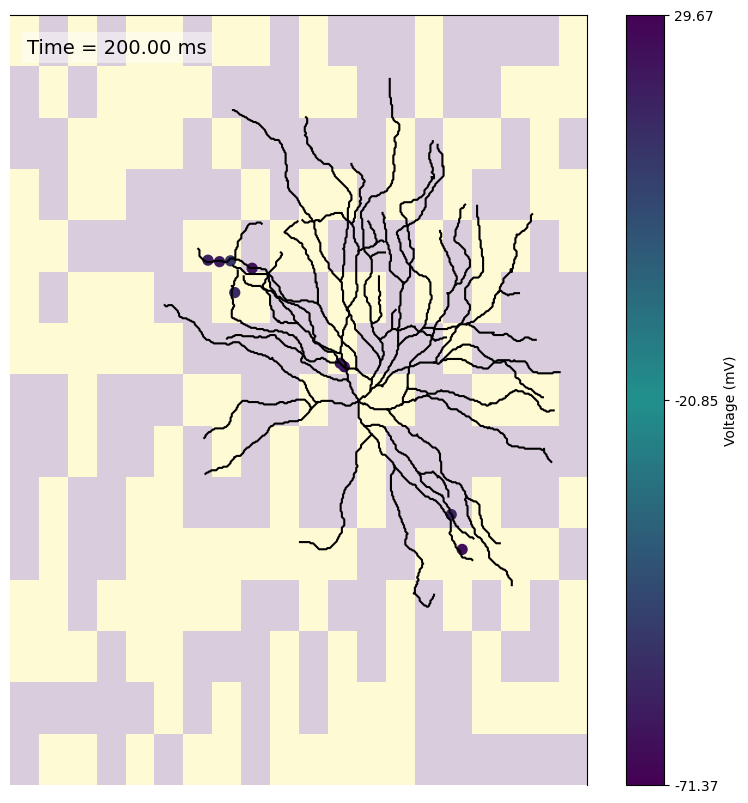

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.animation as animation

# ------------------------------
# 1) Data Setup (Subsample if needed)
# ------------------------------
nr_comps = len(rec_branches_and_compartments)
every_nth = 10  # adjust as needed
v_trained_subsampled = v_trained[:, ::every_nth]
n_time = v_trained_subsampled.shape[1]
time_vec_subsampled = time_vec[::every_nth]

vmin = v_trained_subsampled.min()
vmax = v_trained_subsampled.max()
vmid = 0.5 * (vmin + vmax)

# Create a custom colormap based on 'viridis'
cmap = cm.get_cmap("viridis")
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "adjusted_viridis",
    [cmap(0), cmap((vmid - vmin)/(vmax - vmin)), cmap(1)]
)

# ------------------------------
# 2) Create Figure and Plot Static Elements
# ------------------------------
fig, ax = plt.subplots(figsize=(10, 10))

# Optionally draw static cell morphology if needed:
# cell.vis(ax=ax)

# Draw the static noise image (unchanging background)
pixel_size = 30
rec_id_of_datapoint = int(data_pt_idx // num_datapoints_per_scanfield)
df = setup.loc[setup["rec_id"] == rec_id_of_datapoint].iloc[0]
im_pos_x = np.linspace(-7.5*pixel_size + 0.5, 7.5*pixel_size - 0.5, 15*pixel_size) + df["image_center_x"].item()
im_pos_y = -np.linspace(-10.0*pixel_size + 0.5, 10.0*pixel_size - 0.5, 20*pixel_size) + df["image_center_y"].item()
image = noise_full[:, :, data_pt_idx]
ax.imshow(image, extent=[im_pos_x[0], im_pos_x[-1], im_pos_y[-1], im_pos_y[0]],
          clim=[0, 1], alpha=0.2, cmap="viridis")

# Remove spines and ticks for a cleaner look.
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Draw the cell 
cell.vis(ax=ax)

# Create a colorbar.
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=new_cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Voltage (mV)")
cbar.ax.set_yticks([vmin, vmid, vmax])
cbar.ax.set_yticklabels([f"{vmin:.2f}", f"{vmid:.2f}", f"{vmax:.2f}"])

# Add a text element for the time display.
time_text = ax.text(
    0.03, 0.95, "",
    transform=ax.transAxes,
    fontsize=14,
    color="black",
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
)

# ------------------------------
# 3) Retrieve Compartment Positions and Create Scatter Plot
# ------------------------------
# For each compartment, get its (x, y) coordinates (ignore z).
positions = []
for branch_idx, comp_loc in rec_branches_and_compartments:
    # Assume xyzr returns (x, y, z, r)
    xyzr = np.mean(cell.branch(branch_idx).loc(comp_loc).xyzr[0],axis=0)
    x, y = xyzr[0], xyzr[1]
    positions.append((x, y))
positions = np.array(positions)

# Create an initial list of colors for time index 0.
initial_colors = []
for r in range(nr_comps):
    voltage = v_trained_subsampled[r, 0]
    normalized = (voltage - vmin) / (vmax - vmin)
    initial_colors.append(new_cmap(normalized))

# Create a scatter plot of all compartment points.
scat = ax.scatter(positions[:, 0], positions[:, 1], c=initial_colors, s=50)  # Adjust 's' for dot size

# ------------------------------
# 4) Animation Functions
# ------------------------------
def init_animation():
    # Set the initial time text.
    time_text.set_text(f"Time = {time_vec_subsampled[0]:.2f} ms")
    return [scat, time_text]

def update(frame_idx):
    new_colors = []
    # Update each compartment's color based on voltage.
    for r in range(nr_comps):
        voltage = v_trained_subsampled[r, frame_idx]
        normalized = (voltage - vmin) / (vmax - vmin)
        new_colors.append(new_cmap(normalized))
    scat.set_facecolors(new_colors)
    
    # Update the time display.
    time_text.set_text(f"Time = {time_vec_subsampled[frame_idx]:.2f} ms")
    return [scat, time_text]

# ------------------------------
# 5) Create and Save the Animation
# ------------------------------
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(time_vec_subsampled),
    init_func=init_animation,
    interval=100,   # Interval between frames in ms
    blit=False
)

# Save as GIF using the Pillow writer.
ani.save(f'{save_prefix}/animation.gif', writer='pillow')
plt.show()


### Visualize the response membrane voltage at a certain compartment in this period

## Inspection of parameters

In [79]:
optimal_params_transformed = transform_params.forward(opt_params)
optimal_basal_params_transformed =transform_basal.forward(opt_basal_params)
optimal_somatic_params_transformed =  transform_somatic.forward(opt_somatic_params)


In [85]:

[optimal_params_transformed[i].keys() for i in range(len(optimal_params_transformed))]

[dict_keys(['w_bc_to_rgc']),
 dict_keys(['axial_resistivity']),
 dict_keys(['radius'])]

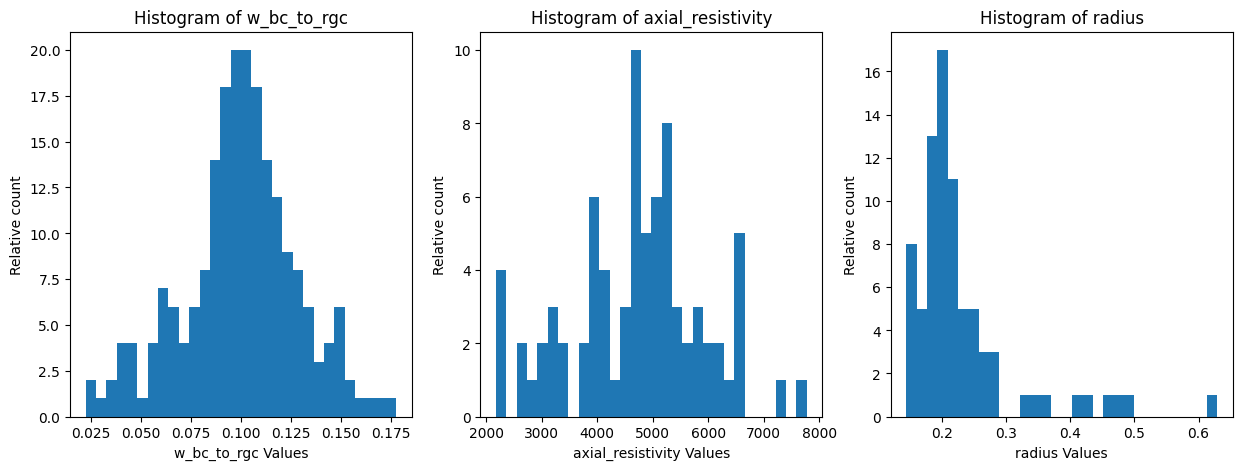

In [ ]:
param_names = ['w_bc_to_rgc','axial_resistivity','radius']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()
for i in range(3):
    axs[i].hist(optimal_params_transformed[i][param_names[i]], bins=30)
    axs[i].set_xlabel(f"{param_names[i]} Values")
    axs[i].set_ylabel("Relative count")
    axs[i].set_title(f"Histogram of {param_names[i]}")


[array([[218.78264546, 188.0599761 ,  33.6000005 ,   0.        ]])]

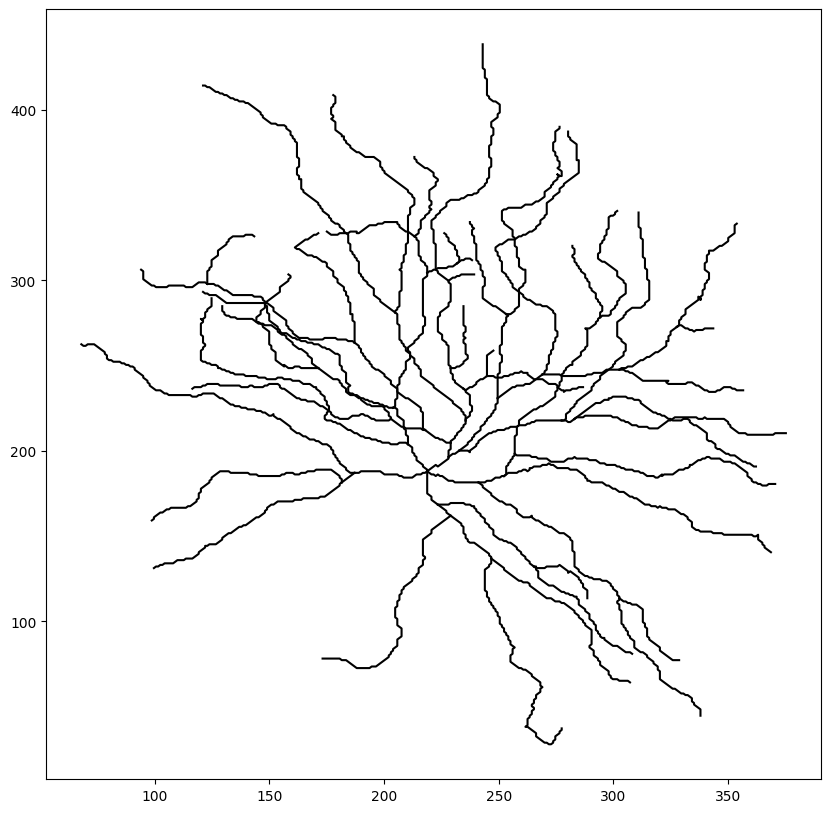

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
cell.vis(ax=ax)


/tmp/ipykernel_540471/3744196748.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")  # Or any other suitable colormap


IndexError: index 1 is out of bounds for axis 0 with size 1

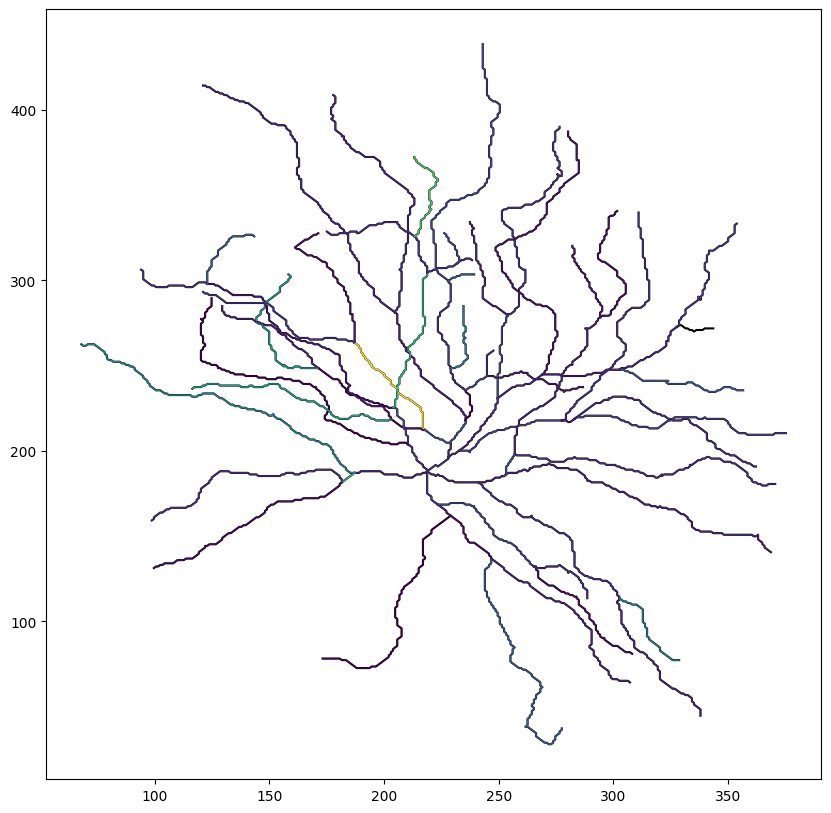

In [ ]:
# # loop over branches, and color code them by radius
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# cell.vis(ax=ax)
# for branch_idx, radius in enumerate(optimal_params_transformed[2]['radius']):
#     cell.branch(branch_idx).vis(ax=ax, color=radius, cmap='viridis')

# plt.colorbar(cm.ScalarMappable(cmap='viridis'), label='Radius')
# plt.show()


# Assuming optimal_params_transformed[2]['radius'] contains radii values.
#  Replace with your actual data if the name is different.
radii = optimal_params_transformed[2]['radius']

# Find min and max radii for normalization
min_radius = np.min(radii)
max_radius = np.max(radii)

# Create a colormap
cmap = cm.get_cmap("viridis")  # Or any other suitable colormap

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cell.vis(ax=ax)

for branch_idx, radius in enumerate(radii):
    # Normalize the radius to the 0-1 range of the colormap
    normalized_radius = (radius - min_radius) / (max_radius - min_radius)
    color = cmap(normalized_radius)  # Get the color from the colormap
    cell.branch(branch_idx).vis(ax=ax, color=color, lw=1) # lw for line width


# Plot the soma red
x,y = cell.soma.xyzr[0][0],cell.soma.xyzr[0][1]
ax.scatter(x,y,color='red',s=100)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_radius, vmax=max_radius))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Radius')

plt.show()

In [81]:
optimal_basal_params_transformed

[{'Na_gNa': Array(0.08174612, dtype=float64)},
 {'K_gK': Array(0.05862315, dtype=float64)},
 {'Leak_gLeak': Array(5.43290793e-05, dtype=float64)},
 {'KA_gKA': Array(0.03432029, dtype=float64)},
 {'Ca_gCa': Array(0.0021322, dtype=float64)},
 {'KCa_gKCa': Array(3.87653744e-05, dtype=float64)}]